## Support vector machines with kernel method


硬间隔与软间隔的支持向量机只适用于线性可分或者大致线性可分的数据集，对于线性不可分的数据集就无能为力了，比如说像这样的数据：

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import os
from sklearn import datasets
%matplotlib inline

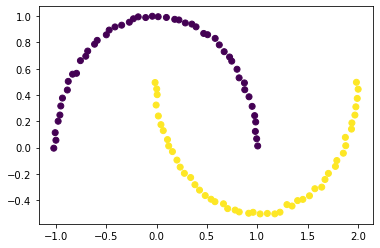

In [32]:
data, target = datasets.make_moons(noise=0.01)
plt.scatter(data[:,0],data[:,1],c=target)
plt.show()

实际上这样的数据才是我们经常会遇到的，对于这样的数据我们需要找一个曲面来把它们进行分割。SVM实际上还只能处理线性可分问题，那么我们可以对数据进行变换，使得它线性可分，例如将二维数据变换到三维空间$(x,y) \rightarrow (x,y,x*y)$。假如将数据变换到三维空间有：


![avatar](../Fig/moon.png)

## kernel methods

基于核方法的SVM实际上有两个步骤：
1. 将低维非线性可分数据$x$，通过一个非线性映射函数$\phi$，映射到一个新空间（高维度甚至是无限维空间）；  
2. 对新空间的数据$\phi(x)$训练线性分类器 

引入高维映射的SVM可以表示为：
$$
\min_{\lambda} \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\lambda_i\lambda_jy_iy_j\phi(x_i)^T\phi(x_j)-\sum_{i=1}^N\lambda_i\\
s.t.\sum_{i=1}^N\lambda_iy_i=0,\\
0\leq\lambda_i\leq C,i=1,2,...,N
$$  
求解得最优$\lambda_i^*$后，SVM模型为：  

$$
f(x)=sign(\sum_{i=1}^N\lambda_iy_i\phi(x_i)^T\phi(x)+b^*)
$$

观察表达式可以看出，求解中包含内积运算$\phi(x_i)^T\phi(x)$，一般情况下$x_i$本身的维度就不低，现在将它变换到更高的维度上会使得计算更加复杂。为了简化算法就想找到一种函数，这种函数输入$(x_i,x_i)$，输出则是$\phi(x_i)^T\phi(x)$，即：
$$
K(x_i,x_j)=\phi(x_i)^T\phi(x_j)
$$  
其中$K(x_i,x_j)$就叫做和函数。

要成为核函数必须满足如下两点条件：  

1. 对称性：$K(x_i,x_j)=K(x_j,x_i)$  

2. 半正定性：对任意的$x_i,i=1,2,..,m$，$K(x,z)$对应的Gramm矩阵：  

$$
K=[K(x_i,x_j)]_{m\times m}
$$  
是半正定矩阵，这里的$x_i\in$可行域，并不要求一定要属于样本集 


常见的核函数有：  

1. 多项式核函数：  

$$
K(x_1,x_2)=(x_1^Tx_2+1)^p
$$  

2. 高斯核函数：  

$$
K(x_1,x_2)=exp(-\frac{\mid\mid x_1-x_2\mid\mid^2}{2\sigma^2})
$$  

一般情况下使用高斯核的性能会好一些，因为有理论证明，当维度映射到无穷维时，所有数据一定都是线性可分的。
假设核函数为高斯核，那么根据核函数的定义有：
$$
K(x_1,x_2)=exp(-\frac{\mid\mid x_1-x_2\mid\mid^2}{2\sigma^2})=\phi(x_1)^T\phi(x_2)
$$ 
其中$\phi(x_1)$是无限维的。

而使用多项式核函数，$\phi(x_1)$是有限维的。



另外，线性可分SVM中使用的是$K(x_1,x_2)=x_1^Tx_2$也是核函数

利用核函数后，软间隔SVM的对偶问题为：  

$$
\min_{\lambda} \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\lambda_i\lambda_jy_iy_jK(x_i,x_j)-\sum_{i=1}^N\lambda_i\\
s.t.\sum_{i=1}^N\lambda_iy_i=0,\\
0\leq\lambda_i\leq C,i=1,2,...,N
$$  
求解得最优$\lambda_i^*$后，SVM模型为：  

$$
f(x)=sign(\sum_{i=1}^N\lambda_iy_iK(x,x_i)+b^*)
$$

In [33]:
def plot_decision_function(X, y, clf, support_vectors=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    # 绘制支持向量
    if support_vectors is not None:
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=80, c='none', alpha=0.7, edgecolor='red')
def sigmoid(x2):
    """
    sigmoid函数
    :param x2:
    :return:
    """
    x = copy.deepcopy(x2)
    if type(x) is int:
        x = 20.0 if x > 20.0 else x
        x = -100.0 if x < -100.0 else x
    else:
        # 避免下溢
        x[x > 20.0] = 20.0
        # 避免上溢
        x[x < -100.0] = -100.0
    return 1 / (1 + np.exp(-x))


In [34]:
"""
该部分放到ml_model.kernel_functions中
"""

def linear():
    """
    线性核函数
    :return:linear function
    """

    def _linear(x, y):
        return np.dot(x, y)

    return _linear


def poly(p=2):
    """
    多项式核函数
    :param p:
    :return: poly function
    """

    def _poly(x, y):
        return np.power(np.dot(x, y) + 1, p)

    return _poly


def rbf(sigma=0.1):
    """
    径向基/高斯核函数
    :param sigma:
    :return:
    """

    def _rbf(x, y):
        np_x = np.asarray(x)
        if np_x.ndim <= 1:
            return np.exp((-1 * np.dot(x - y, x - y) / (2 * sigma * sigma)))
        else:
            return np.exp((-1 * np.multiply(x - y, x - y).sum(axis=1) / (2 * sigma * sigma)))

    return _rbf

In [35]:

class SVC(object):
    def __init__(self, epochs=100, C=1.0, tol=1e-3, kernel=None, degree=3, gamma=0.1):
        """
        :param epochs: 迭代次数上限
        :param C: C越小，对于误分类的惩罚越小
        :param tol:提前中止训练时的误差值上限，避免迭代太久
        :param kernel:核函数
        :param degree:kernel='poly'时生效
        :param gamma:kernel='rbf'时生效
        """
        self.b = None
        self.alpha = None
        self.E = None
        self.epochs = epochs
        self.C = C
        self.tol = tol
        # 定义核函数
        if kernel is None:
            self.kernel_function = linear()
        elif kernel == 'poly':
            self.kernel_function = poly(degree)
        elif kernel == 'rbf':
            self.kernel_function = rbf(gamma)
        else:
            self.kernel_function = linear()
        # 记录支持向量
        self.support_vectors = None
        # 记录支持向量的x
        self.support_vector_x = []
        # 记录支持向量的y
        self.support_vector_y = []
        # 记录支持向量的alpha
        self.support_vector_alpha = []

    def f(self, x):
        """
        :param x:
        :return: wx+b
        """
        x_np = np.asarray(x)
        if len(self.support_vector_x) == 0:
            if x_np.ndim <= 1:
                return 0
            else:
                return np.zeros((x_np.shape[:-1]))
        else:
            if x_np.ndim <= 1:
                wx = 0
            else:
                wx = np.zeros((x_np.shape[:-1]))
            for i in range(0, len(self.support_vector_x)):
                wx += self.kernel_function(x, self.support_vector_x[i]) * self.support_vector_alpha[i] * \
                      self.support_vector_y[i]
            return wx + self.b

    def init_params(self, X, y):
        """
        :param X: (n_samples,n_features)
        :param y: (n_samples,) y_i\in\{0,1\}
        :return:
        """
        n_samples, n_features = X.shape
        self.b = .0
        self.alpha = np.zeros(n_samples)
        self.E = np.zeros(n_samples)
        # 初始化E
        for i in range(0, n_samples):
            self.E[i] = self.f(X[i, :]) - y[i]

    def _select_j(self, best_i):
        """
        选择j
        :param best_i:
        :return:
        """
        valid_j_list = [i for i in range(0, len(self.alpha)) if self.alpha[i] > 0 and i != best_i]
        best_j = -1
        # 优先选择使得|E_i-E_j|最大的j
        if len(valid_j_list) > 0:
            max_e = 0
            for j in valid_j_list:
                current_e = np.abs(self.E[best_i] - self.E[j])
                if current_e > max_e:
                    best_j = j
                    max_e = current_e
        else:
            # 随机选择
            l = list(range(len(self.alpha)))
            seq = l[: best_i] + l[best_i + 1:]
            best_j = random.choice(seq)
        return best_j

    def _meet_kkt(self, x_i, y_i, alpha_i):
        """
        判断是否满足KKT条件

        :param w:
        :param b:
        :param x_i:
        :param y_i:
        :return:
        """
        if alpha_i < self.C:
            return y_i * self.f(x_i) >= 1 - self.tol
        else:
            return y_i * self.f(x_i) <= 1 + self.tol

    def fit(self, X, y2, show_train_process=False):
        """

        :param X:
        :param y2:
        :param show_train_process: 显示训练过程
        :return:
        """
        y = copy.deepcopy(y2)
        y[y == 0] = -1
        # 初始化参数
        self.init_params(X, y)
        for _ in range(0, self.epochs):
            if_all_match_kkt = True
            for i in range(0, len(self.alpha)):
                x_i = X[i, :]
                y_i = y[i]
                alpha_i_old = self.alpha[i]
                E_i_old = self.E[i]
                # 外层循环：选择违反KKT条件的点i
                if not self._meet_kkt(x_i, y_i, alpha_i_old):
                    if_all_match_kkt = False
                    # 内层循环，选择使|Ei-Ej|最大的点j
                    best_j = self._select_j(i)

                    alpha_j_old = self.alpha[best_j]
                    x_j = X[best_j, :]
                    y_j = y[best_j]
                    E_j_old = self.E[best_j]

                    # 进行更新
                    # 1.首先获取无裁剪的最优alpha_2
                    eta = self.kernel_function(x_i, x_i) + self.kernel_function(x_j, x_j) - 2.0 * self.kernel_function(
                        x_i, x_j)
                    # 如果x_i和x_j很接近，则跳过
                    if eta < 1e-3:
                        continue
                    alpha_j_unc = alpha_j_old + y_j * (E_i_old - E_j_old) / eta
                    # 2.裁剪并得到new alpha_2
                    if y_i == y_j:
                        L = max(0., alpha_i_old + alpha_j_old - self.C)
                        H = min(self.C, alpha_i_old + alpha_j_old)
                    else:
                        L = max(0, alpha_j_old - alpha_i_old)
                        H = min(self.C, self.C + alpha_j_old - alpha_i_old)

                    if alpha_j_unc < L:
                        alpha_j_new = L
                    elif alpha_j_unc > H:
                        alpha_j_new = H
                    else:
                        alpha_j_new = alpha_j_unc

                    # 如果变化不够大则跳过
                    if np.abs(alpha_j_new - alpha_j_old) < 1e-5:
                        continue
                    # 3.得到alpha_1_new
                    alpha_i_new = alpha_i_old + y_i * y_j * (alpha_j_old - alpha_j_new)
                    # 5.更新alpha_1,alpha_2
                    self.alpha[i] = alpha_i_new
                    self.alpha[best_j] = alpha_j_new
                    # 6.更新b
                    b_i_new = y_i - self.f(x_i) + self.b
                    b_j_new = y_j - self.f(x_j) + self.b
                    if self.C > alpha_i_new > 0:
                        self.b = b_i_new
                    elif self.C > alpha_j_new > 0:
                        self.b = b_j_new
                    else:
                        self.b = (b_i_new + b_j_new) / 2.0
                    # 7.更新E
                    for k in range(0, len(self.E)):
                        self.E[k] = self.f(X[k, :]) - y[k]

                    # 8.更新支持向量相关的信息
                    self.support_vectors = np.where(self.alpha > 1e-3)[0]
                    self.support_vector_x = [X[i, :] for i in self.support_vectors]
                    self.support_vector_y = [y[i] for i in self.support_vectors]
                    self.support_vector_alpha = [self.alpha[i] for i in self.support_vectors]

                    # 显示训练过程
                    # if show_train_process is True:
                    #     utils.plot_decision_function(X, y2, self, [i, best_j])
                    #     utils.plt.pause(0.1)
                    #     utils.plt.clf()

            # 如果所有的点都满足KKT条件，则中止
            if if_all_match_kkt is True:
                break

        # 显示最终结果
        if show_train_process is True:
            plot_decision_function(X, y2, self, self.support_vectors)
            plt.show()

    def get_params(self):
        """
        输出原始的系数
        :return: w
        """

        return self.w, self.b

    def predict_proba(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        return sigmoid(self.f(x))

    def predict(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        proba = self.predict_proba(x)
        return (proba >= 0.5).astype(int)

### 基于高斯核函数的分类结构

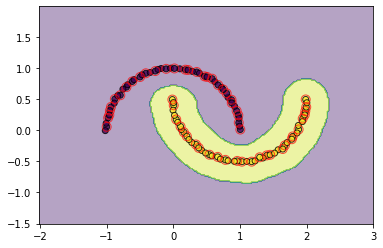

In [36]:
svm = SVC(C=3.0, kernel='rbf',gamma=0.1, epochs=10, tol=0.2)
svm.fit(data, target)
plot_decision_function(data, target, svm, svm.support_vectors)

### 基于多项式核函数的分类结果

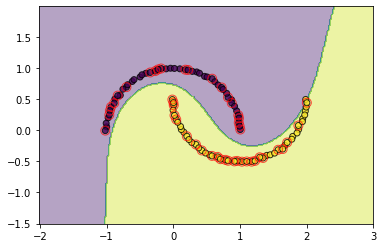

In [37]:
svm = SVC(C=3.0, kernel='poly',degree=3, epochs=10, tol=0.2)
svm.fit(data, target)
plot_decision_function(data, target, svm, svm.support_vectors)